In [2]:
from math import log
from operator import itemgetter
import numpy as np

def readData(filename):
    dataSet = []
    with open(filename,encoding='utf-8') as f:
        for line in f:
            x1,x2,y=line.strip().split(" ")
            dataSet.append([x1,x2,y])
    f.close()
    labels = ['Xn1','Xn2']

    return dataSet, labels

def calculateEntropy(dataSet,index): 
    # calculate the Shannon entropy
    entropy = 0.0
    targetSet = [data[index] for data in dataSet] 
    instances = set(targetSet)
    
    for value in instances:
        prob = targetSet.count(value)/len(dataSet)
        entropy -= prob * (log(prob)/log(2))
        
    return entropy

def detemineCandidateNumericSplits(dataSet,index):
    '''
    Given a dataset D and a specific feature index to sort the values of Xi in D 
    Evaluate split thresholds in intervals between instances of different classes
    
    return the candidate splits
    '''
    C = []
    sortedData = sorted(dataSet, key = itemgetter(index))
    previousLabel = ''
    for data in sortedData:
        if(previousLabel == ''): 
            previousLabel = data[-1]
        else:
            if(data[-1] != previousLabel):
                previousLabel = data[-1]
                C.append(data[index]) 
    return C
            
def splitDataSet(dataSet, index, value, mode):
    # index : split the dataset according to the ith feature
    # value : given the selected feature, split the dataset with respect to the value
    # mode : 
    # 1 - split data with feature greater or equal to value
    # 2 - less than the value
    # 3 - equal to the value
   
    feature = []
    subDataSet = []
    if(mode == 1):
        for feature in dataSet:
            if feature[index] >= value: 
                subDataSet.append(feature[:])
    elif(mode == 2):
        for feature in dataSet:
            if feature[index] < value: 
                subDataSet.append(feature[:])
    elif(mode == 3):
        for feature in dataSet:
            if feature[index] == value: 
                subDataSet.append(feature[:])
                
    return subDataSet

def findBestSplit(dataSet):
    # find the split with largest info gain ratio from the candidate splits
    feature = len(dataSet[0]) - 1  # ith feature
    entropy = calculateEntropy(dataSet,-1)
    bestInfoGainRatio = 0.0
    bestFeatureIndex = -1
    bestValue = 0.0
    for i in range(feature):  # for every feature
        candidate = detemineCandidateNumericSplits(dataSet, i)
    
        for value in candidate: # calculate info gain ratio for the value in our candidate set
            
            conditionalEntropy = 0.0
            entropy_value = 0.0  # entropy of split the data with ith feature and value
            
            subDataSet_1 = splitDataSet(dataSet, i, value, mode = 1) # sub dataset with ith feature >= value       
            subDataSet_2 = splitDataSet(dataSet, i, value, mode = 2) # sub dataset with ith feature < value
           
            if(len(subDataSet_1)!=0 and len(subDataSet_2)!=0): # avoid the math domain error (prob == 0) 
                # probability of ith feature >= certain value
                prob_1 = len(subDataSet_1) / float(len(dataSet)) 
                # probability of ith feature < certain value
                prob_2 = len(subDataSet_2) / float(len(dataSet)) 

                conditionalEntropy = prob_1 * calculateEntropy(subDataSet_1,-1)
                conditionalEntropy += prob_2 * calculateEntropy(subDataSet_2,-1)

                entropy_value = -prob_1 * (log(prob_1)/log(2))
                entropy_value += -prob_2 * (log(prob_2)/log(2))

                infoGain = entropy - conditionalEntropy
                infoGainRatio = infoGain/entropy_value

                if (infoGainRatio > bestInfoGainRatio): 
                    bestInfoGainRatio = infoGainRatio
                    bestFeatureIndex = i
                    bestValue = value

    return bestFeatureIndex, bestValue

def majorityCount(classList):
    # count the majority label in a given dataset
    # the label appeared most frequently
    classCount = {}
    for data in classList:
        if data not in classCount.keys(): 
            classCount[data] = 0
        classCount[data] += 1
    sortedClassCount = sorted(classCount.items(),key=itemgetter(1), reverse=True)
    
    return sortedClassCount

def createTree(dataSet, node_num = 0):
    #main function to create decision tree
    
    bestFeature, bestValue = findBestSplit(dataSet) 
    classList = [data[-1] for data in dataSet] 
    
    if(len(dataSet) == 0):
        return
    elif(bestFeature == -1):
        sortedClassCount = majorityCount(classList)
        if(len(sortedClassCount) == 2 and sortedClassCount[0][1] == sortedClassCount[1][1]):
            node_num += 1
            return 1, node_num
        else:
            node_num += 1
            return int(sortedClassCount[0][0]), node_num
    
    myTree = {'feature': int(bestFeature), 'threshold': float(bestValue), 'left':{}, 'right':{}}

    myTree['right'], num1 = createTree(splitDataSet(dataSet, bestFeature, bestValue, mode = 1), node_num)
    myTree['left'], num2 = createTree(splitDataSet(dataSet, bestFeature, bestValue, mode = 2), node_num)
    node_num = node_num + num1 + num2 + 1
    return myTree, node_num

dataSet, labels = readData('data/D2.txt')
tree, num = createTree(dataSet)

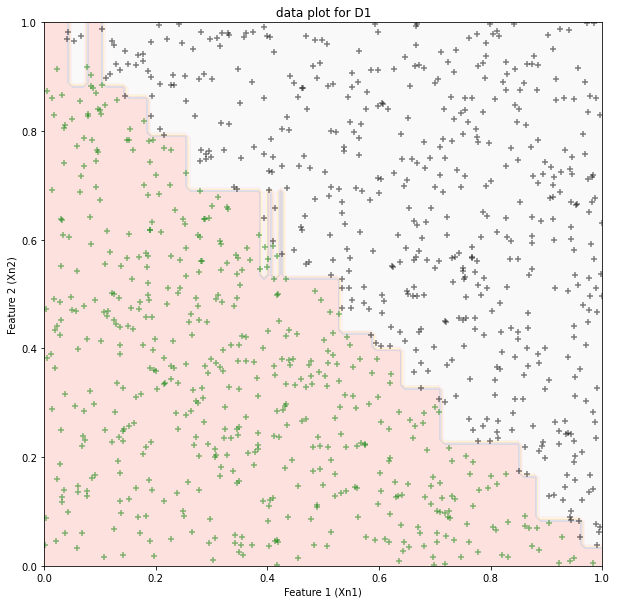

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Give the read data
dataSet, labels = readData('data/D2.txt')
tree,num_node = createTree(dataSet)

# Define the function to predict the target variable given an input and a decision tree
def predict_tree(x, tree):
    # x : a instance of data
    # tree: the decision tree in dictionary form
    if type(tree) == int:
        return tree
    if float(x[tree['feature']]) <= tree['threshold']:
        return predict_tree(x, tree['left'])
    else:
        return predict_tree(x, tree['right'])

# Obtain the real data
xn1 = [float(example[0]) for example in dataSet]
xn2 = [float(example[1]) for example in dataSet]
labels = [example[2] for example in dataSet]

# Assign the label with different color
for i in range(len(labels)):
    if(labels[i] == '0'):
        labels[i] = 'green'
    elif(labels[i] == '1'):
        labels[i] = 'black'

# Define the range of values for the features
x0 = np.linspace(0, 1, 100)
x1 = np.linspace(0, 1, 100)

# Generate a grid of points to evaluate the decision tree on
X0, X1 = np.meshgrid(x0, x1)
X = np.c_[X0.ravel(), X1.ravel()]

# Evaluate the decision tree on the grid of points
y = np.array([predict_tree(x, tree) for x in X])

# Figure setting
plt.figure(figsize = (10,10))
plt.title('data plot for D1')

# Plot the decision boundary
plt.contourf(X0, X1, y.reshape(X0.shape), cmap='Pastel1', alpha=0.4)
#plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Pastel1')

# Label of figure
plt.xlabel('Feature 1 (Xn1)')
plt.ylabel('Feature 2 (Xn2)')

# Plot the real data
plt.scatter(xn1,xn2,alpha=0.5, marker='+', c=labels)

plt.show()

N:32 Number of node: 19 Error: 0.5221238938053098
N:128 Number of node: 23 Error: 0.536504424778761
N:512 Number of node: 61 Error: 0.48064159292035397
N:2048 Number of node: 123 Error: 0.4651548672566372
N:8192 Number of node: 277 Error: 0.4657079646017699


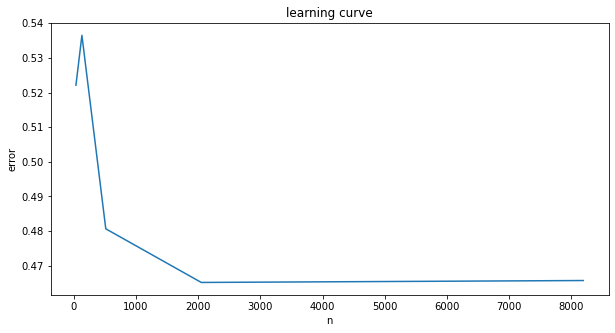

In [5]:
import random

def errorRate(testSet,tree):
    # calculte the error rate
    # rate = wrong predict / total number of instances
    count = 0
    y = np.array([example[2] for example in testSet])
    y_hat = np.array([predict_tree(x, tree) for x in testSet])
    for i in range(len(y)):
        if(int(y[i])!=int(y_hat[i])):
            count += 1
    error = count/len(y)  
    return error

# Give the read data
dataSet, labels = readData('data/Dbig.txt')

# shuffle the data
random.shuffle(dataSet)

train = dataSet[0:8192]
test = dataSet[8192:]
# then split the train size to different value

# size 32
random.shuffle(train)
train_32 = train[0:32]

# size 128
random.shuffle(train)
train_128 = train[0:128]

# size 512
random.shuffle(train)
train_512 = train[0:512]

# size 2048
random.shuffle(train)
train_2048 = train[0:2048]

# size 8192
train_8192 = train

tree_32, num_32 = createTree(train_32)
tree_128, num_128 = createTree(train_128)
tree_512, num_512 = createTree(train_512)
tree_2048, num_2048 = createTree(train_2048)
tree_8192, num_8192 = createTree(train_8192)

err_32 = errorRate(test,tree_32)
err_128 = errorRate(test,tree_128)
err_512 = errorRate(test,tree_512)
err_2048 = errorRate(test,tree_2048)
err_8192 = errorRate(test,tree_8192)

# print results
print("N:32","Number of node:",num_32,"Error:",err_32)
print("N:128","Number of node:",num_128,"Error:",err_128)
print("N:512","Number of node:",num_512,"Error:",err_512)
print("N:2048","Number of node:",num_2048,"Error:",err_2048)
print("N:8192","Number of node:",num_8192,"Error:",err_8192) 

# plot learning curve
n = [32,128,512,2048,8192]
err = [err_32,err_128,err_512,err_2048,err_8192]

plt.figure(figsize = (10,5))
plt.title('learning curve')
plt.plot(n,err)
plt.xlabel('n')
plt.ylabel('error')

plt.show()

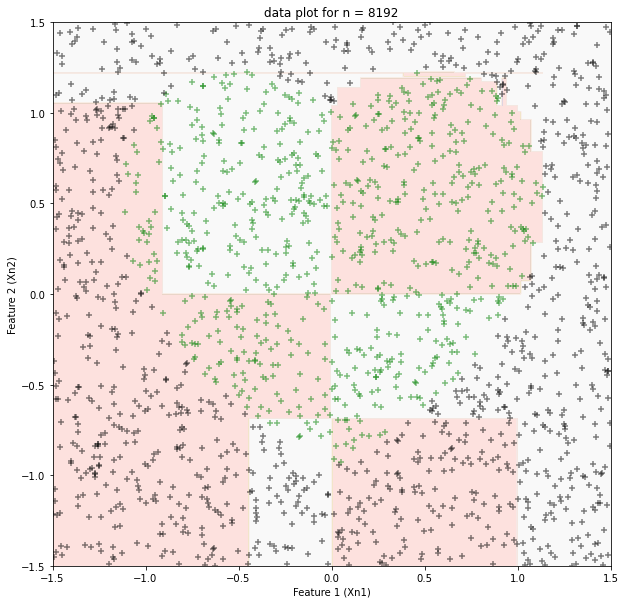

In [11]:
# plot the decision boundary for tree with different train set size
dataSet = test
tree = tree_8192

# Obtain the real data
xn1 = [float(example[0]) for example in dataSet]
xn2 = [float(example[1]) for example in dataSet]
labels = [example[2] for example in dataSet]

# Assign the label with different color
for i in range(len(labels)):
    if(labels[i] == '0'):
        labels[i] = 'green'
    elif(labels[i] == '1'):
        labels[i] = 'black'

# Define the range of values for the features
x0 = np.linspace(-1.5, 1.5, 1000)
x1 = np.linspace(-1.5, 1.5, 1000)

# Generate a grid of points to evaluate the decision tree on
X0, X1 = np.meshgrid(x0, x1)
X = np.c_[X0.ravel(), X1.ravel()]

# Evaluate the decision tree on the grid of points
y = np.array([predict_tree(x, tree) for x in X])

# Figure setting
plt.figure(figsize = (10,10))
plt.title('data plot for n = 8192')

# Plot the decision boundary
plt.contourf(X0, X1, y.reshape(X0.shape), cmap='Pastel1', alpha=0.4)

# Label of figure
plt.xlabel('Feature 1 (Xn1)')
plt.ylabel('Feature 2 (Xn2)')

# Plot the real data
plt.scatter(xn1,xn2,alpha=0.5, marker='+', c=labels)

plt.show()